In [0]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline
train  = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [22]:
train.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1


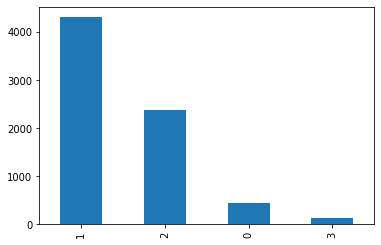

In [23]:
train['sentiment'].value_counts().plot(kind='bar')

In [0]:
combi = train.append(test, ignore_index=True)
combi
# function to remove unwanted patterns
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt  
# remove twitter handles (@user)
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'].astype(str), "@[\w]*")
# remove special characters, numbers, punctuations
combi['tidy_tweet'] = combi['tidy_tweet'].astype(str).replace("[^a-zA-Z#]", " ")

In [0]:
# remove hashtag
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'].astype(str), "#")


In [0]:
combi['tidy_tweet']

In [5]:
#!pip install vaderSentiment
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#analyser = SentimentIntensityAnalyzer()
#def sentiment_analyzer_scores(sentence):
#    score = analyser.polarity_scores(sentence)
#    print("{:-<40} {}".format(sentence, str(score)))


#sentiment_analyzer_scores(combi['tidy_tweet'][0])



#def calculate_sentiment_analyser(Clean_text):    
#    return analyser.polarity_scores(Clean_text)

#calculate_sentiment_analyser(combi['tidy_tweet'][0])


#combi["sentiments_polarity"] = combi['tidy_tweet'].apply(lambda x: sentiment_analyzer_scores(x))


     |████████████████████████████████| 133kB 2.8MB/s 


In [32]:
combi.head()

,sentiment,tweet,tweet_id,tidy_tweet
0,1.0,#sxswnui #sxsw #apple defining language of tou...,1701,sxswnui sxsw apple defining language of touch ...
1,1.0,Learning ab Google doodles! All doodles should...,1851,Learning ab Google doodles! All doodles should...
2,2.0,one of the most in-your-face ex. of stealing t...,2689,one of the most in-your-face ex. of stealing t...
3,0.0,This iPhone #SXSW app would b pretty awesome i...,4525,This iPhone SXSW app would b pretty awesome if...
4,1.0,Line outside the Apple store in Austin waiting...,3604,Line outside the Apple store in Austin waiting...


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


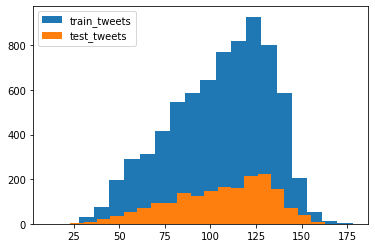

In [27]:
length_train = train['tweet'].str.len()
length_test = test['tweet'].str.len()

plt.hist(length_train, bins=20, label="train_tweets")
plt.hist(length_test, bins=20, label="test_tweets")
plt.legend()
plt.show()

In [0]:
# remove special characters, numbers, punctuations
combi['tidy_tweet'] = combi['tidy_tweet'].astype(str).replace("[^a-zA-Z#]", " ")

#removing short words
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [34]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
#Tokenization
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [sxswnui, sxsw, appl, defin, languag, touch, w...
1    [learn, googl, doodles!, doodl, should, light,...
2    [most, in-your-fac, steal, show, @mention, &qu...
3    [thi, iphon, sxsw, would, pretti, awesom, didn...
4    [line, outsid, appl, store, austin, wait, ipad...
Name: tidy_tweet, dtype: object

In [36]:
#Now let’s stitch these tokens back together.
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['tidy_tweet'] = tokenized_tweet
combi['tidy_tweet']


0       sxswnui sxsw appl defin languag touch with dif...
1       learn googl doodles! doodl should light, funni...
2       most in-your-fac steal show @mention &quot;at ...
3       thi iphon sxsw would pretti awesom didn't cras...
4       line outsid appl store austin wait ipad sxsw {...
                              ...                        
9088    @mention @mention @mention hmmm....how fast ap...
9089    samsung galaxi appear team android sxsw parti ...
9090    @mention could ipad tmrw appl pop-up store sxs...
9091    veri long queue peopl appl store now, some hav...
9092    privaci could headlin googl circl social netwo...
Name: tidy_tweet, Length: 9093, dtype: object

In [37]:
#Extracting Features from Cleaned Tweets

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

#Bag-of-Words Features
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])
bow.shape




(9093, 1000)

<9093x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 92944 stored elements in Compressed Sparse Row format>

In [38]:
#TF-IDF Features¶
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])
tfidf.shape

(9093, 1000)

In [60]:
# Building model using Bag-of-Words features
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score

train_bow = bow[:7274,:]
test_bow = bow[7274:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['sentiment'], random_state=42, test_size=0.3)

# 1.1 applying log regression model on bag of words
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction_lreg_bow = lreg.predict(xvalid_bow) # predicting on the validation set
f1_score(yvalid,prediction_lreg_bow,average='weighted') # calculating f1 score

#final validation set 
prediction_lreg_val_bow = lreg.predict(test_bow) # predicting on the test set given seperately
test['sentiment'] = prediction_lreg_val_bow
submission = test[['tweet_id','sentiment']]
submission
submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
train_tfidf = tfidf[:7274,:]
test_tfidf = tfidf[7274:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

In [0]:
#1.2 applying log regression model on TFIDF

lreg.fit(xtrain_tfidf, ytrain)

prediction_lreg_tfidf = lreg.predict(xvalid_tfidf)
print(f1_score(yvalid,prediction_lreg_tfidf,average='weighted')) # calculating f1 score


#final validation set 
prediction_lreg_val_tfidf = lreg.predict(test_bow) # predicting on the test set given seperately
test['sentiment'] = prediction_lreg_val_tfidf
submission = test[['tweet_id','sentiment']]
submission
submission.to_csv('sub_lreg_tfidf.csv', index=False) # writing data to a CSV file

In [62]:
# 2.1 Support Vector Machine¶
from sklearn import svm
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain)

prediction_svc_bow = svc.predict(xvalid_bow)

print(f1_score(yvalid, prediction_svc_bow, average='weighted'))

#final validation set 
prediction_svc_val_bow = svc.predict(test_bow) # predicting on the test set given seperately
test['sentiment'] = prediction_svc_val_bow
submission = test[['tweet_id','sentiment']]
submission
submission.to_csv('sub_svc_bow.csv', index=False) # writing data to a CSV file



0.6194039374457806


In [63]:
#2.2 SVM with TFIDF
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain)

prediction_svc_tfidf = svc.predict(xvalid_tfidf)
print(f1_score(yvalid, prediction_svc_tfidf, average='weighted'))

#final validation set 
prediction_svc_val_tfidf = svc.predict(test_bow) # predicting on the test set given seperately
test['sentiment'] = prediction_svc_val_tfidf
submission = test[['tweet_id','sentiment']]
submission
submission.to_csv('sub_svc_tfidf.csv', index=False) # writing data to a CSV file



0.6126649877365693


In [69]:
#3.1 RandomForest with BOW
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=400, random_state=42).fit(xtrain_bow, ytrain)

prediction_rf_bow = rf.predict(xvalid_bow)

print(f1_score(yvalid, prediction_rf_bow, average='weighted'))

#final validation set 
prediction_rf_val_bow = rf.predict(test_bow) # predicting on the test set given seperately
test['sentiment'] = prediction_rf_val_bow
submission = test[['tweet_id','sentiment']]
submission
submission.to_csv('sub_rf_bow.csv', index=False) # writing data to a CSV file




0.6342464460307682


In [68]:
# RandomForest with TFIDF
rf = RandomForestClassifier(n_estimators=400, random_state=42).fit(xtrain_tfidf, ytrain)

prediction_rf_tfidf = rf.predict(xvalid_tfidf)

print(f1_score(yvalid, prediction_rf_tfidf , average='weighted'))

#final validation set 
prediction_rf_val_tfidf = rf.predict(test_bow) # predicting on the test set given seperately
test['sentiment'] = prediction_rf_val_tfidf
submission = test[['tweet_id','sentiment']]
submission
submission.to_csv('sub_rf_tfidf.csv', index=False) # writing data to a CSV file




0.6254982809312195


In [75]:
#4.1. XGBoost with BOW
from xgboost import XGBClassifier

xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow, ytrain)
prediction_xgb_model = xgb_model.predict(xvalid_bow)

print(f1_score(yvalid, prediction_xgb_model , average='weighted'))


#final validation set 
prediction_xgb_val_bow = xgb_model.predict(test_bow) # predicting on the test set given seperately
test['sentiment'] = prediction_xgb_val_bow
submission = test[['tweet_id','sentiment']]
submission
submission.to_csv('sub_xgb_bow.csv', index=False) # writing data to a CSV file


0.6476111759076212


In [77]:
#4.2 XGB with TFIDF
xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_tfidf, ytrain)

prediction_xgb_tfidf = xgb.predict(xvalid_tfidf)
print(f1_score(yvalid,prediction_xgb_tfidf ,average='weighted'))

#final validation set 
prediction_xgb_tfidf = xgb.predict(test_bow) # predicting on the test set given seperately
test['sentiment'] = prediction_xgb_tfidf
submission = test[['tweet_id','sentiment']]
submission
submission.to_csv('sub_xgb_tfidf.csv', index=False) # writing data to a CSV file


0.6297995725369903


In [0]:
bow_vectorizer_ngram = CountVectorizer(max_df=0.90, min_df=2, max_features=80000, ngram_range = (1,3))
bow2 = bow_vectorizer_ngram.fit_transform(combi['tidy_tweet'])
bow2

train_bow2 = bow2[:7274,:]
test_bow2 = bow2[7274:,:]
# splitting data into training and validation set
xtrain_bow2, xvalid_bow2, ytrain2, yvalid2 = train_test_split(train_bow2, train['sentiment'], random_state=42, test_size=0.3)


In [87]:

### XGB with ngram = 3 and bag of words
xgb_model2 = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow2, ytrain2)
prediction_xgb_model2 = xgb_model2.predict(xvalid_bow2)

print(f1_score(yvalid2, prediction_xgb_model2 , average='weighted'))


#final validation set 
prediction_xgb_val_bow2 = xgb_model2.predict(test_bow2) # predicting on the test set given seperately
test['sentiment'] = prediction_xgb_val_bow2
submission = test[['tweet_id','sentiment']]
submission
submission.to_csv('sub_xgb_bow_ngram3.csv', index=False) # writing data to a CSV file


0.6427508250786191


In [94]:
## 1.1 applying log regression model on bag of words

lreg = LogisticRegression(class_weight= 'balanced')

lreg.fit(xtrain_bow2, ytrain2) # training the model

prediction_lreg_bow2 = lreg.predict(xvalid_bow2) # predicting on the validation set
print(f1_score(yvalid2,prediction_lreg_bow2,average='weighted')) # calculating f1 score

#final validation set 
prediction_lreg_val_bow2 = lreg.predict(test_bow2) # predicting on the test set given seperately
test['sentiment'] = prediction_lreg_val_bow2
submission = test[['tweet_id','sentiment']]
submission
submission.to_csv('sub_lreg_bow_ngram3.csv', index=False) # writing data to a CSV file


0.6487852096306046


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [96]:
#3.1 RandomForest with BOW
from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced').fit(xtrain_bow2, ytrain2)

prediction_rf_bow2 = rf2.predict(xvalid_bow2)

print(f1_score(yvalid2, prediction_rf_bow2, average='weighted'))

#final validation set 
prediction_rf_val_bow2 = rf2.predict(test_bow2) # predicting on the test set given seperately
test['sentiment'] = prediction_rf_val_bow2
submission = test[['tweet_id','sentiment']]
submission
submission.to_csv('sub_rf_bow2_ngram3_balanced.csv', index=False) # writing data to a CSV file


0.6080848447913078
